# Data Augmentation with CutMix
The following implementation of *cutmix for use with bounding boxes* is based on the Kaggle notebook found [here](https://www.kaggle.com/code/shonenkov/oof-evaluation-mixup-efficientdet) by **Alex Shonenkov**

In [1]:
import pandas as pd
import pathlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#import utilities
import sys
sys.path.append('src/')
import utils as utils
from preprocessing3 import *

In [2]:
# define training and save paths and read in training csv and label key
data_dir = pathlib.Path('gwhd_2021/images/')
images = list(data_dir.glob('*.jpg'))

In [3]:
# Import data
metadata = pd.read_csv('gwhd_2021/metadata_dataset.csv', sep=';')
train = pd.read_csv('gwhd_2021/competition_train.csv')

# Update metadata['name'] to metadata['domain'] to match full column name
metadata.rename(columns = {"name": "domain"}, inplace=True)

In [4]:
# Merge dfs and preprocess
train_df = train.merge(metadata, on='domain')
train_df = utils.preprocess_df(train_df)

In [5]:
train_image_ids = train_df.image_name.unique()

train_dataset = WheatDataset(
    image_ids=train_image_ids,
    labels_df= train_df,
    transforms=get_train_transforms(),
    test=False
)

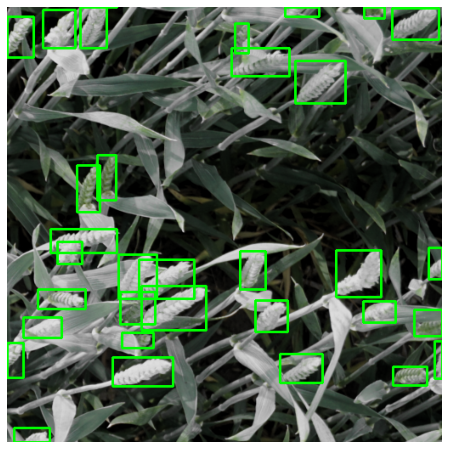

In [6]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image)

## Mix-up #1
Full-sized images 1:1

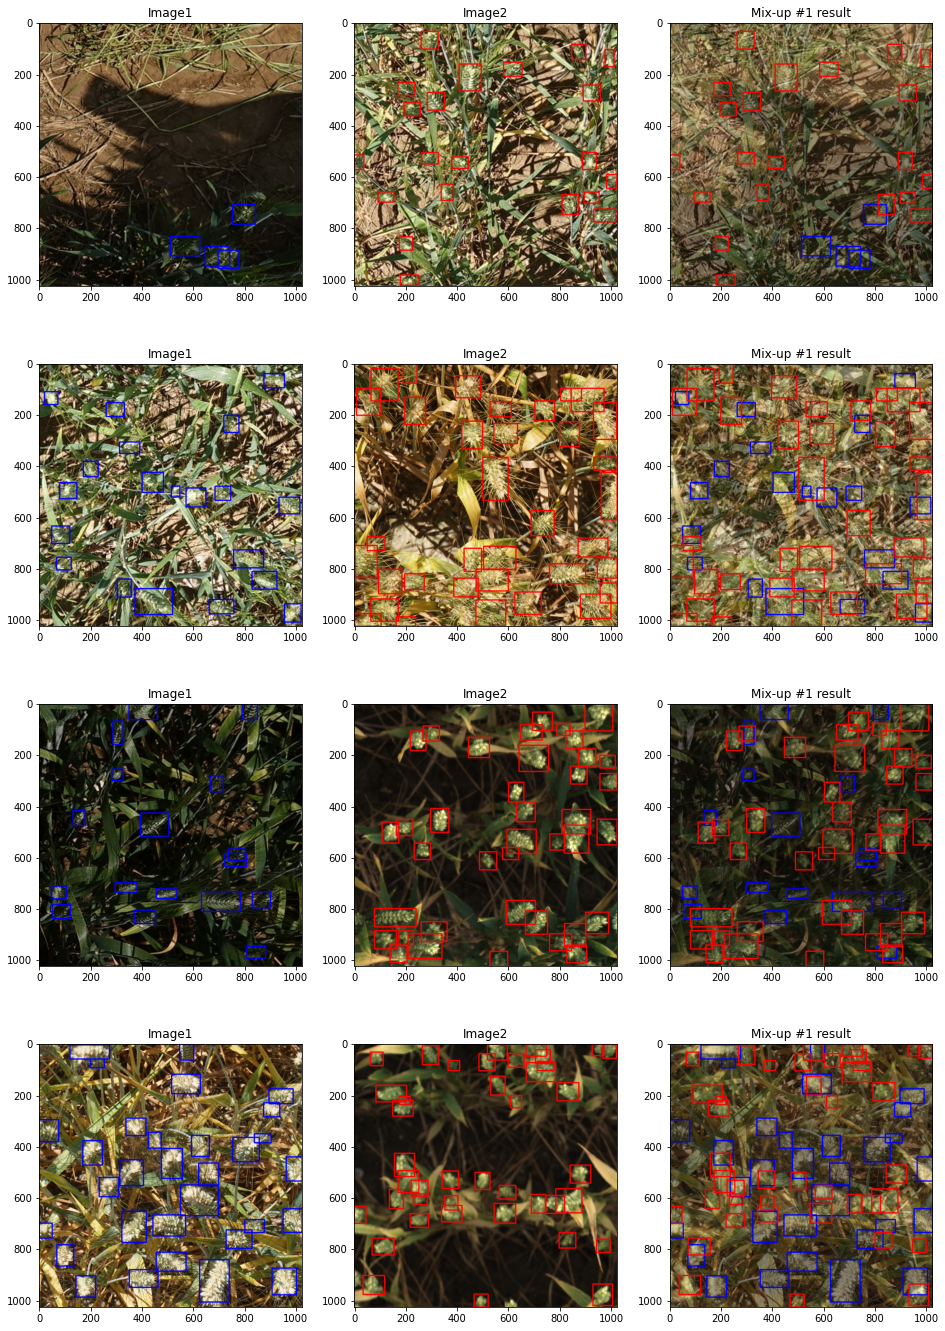

In [12]:
count = 4

fig, ax = plt.subplots(count, 3, figsize=(16, 6*count))

for i in range(count):
    image, boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    r_image, r_boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    mixup_image = (image+r_image)/2

    for box in boxes.astype(int):
        cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        
    for box in r_boxes.astype(int):
        cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        
    ax[i][0].imshow(image)
    ax[i][0].set_title('Image1')

    ax[i][1].imshow(r_image)
    ax[i][1].set_title('Image2')
    
    ax[i][2].imshow(mixup_image)
    ax[i][2].set_title('Mix-up #1 result')

## Mix-up #2
Random selection

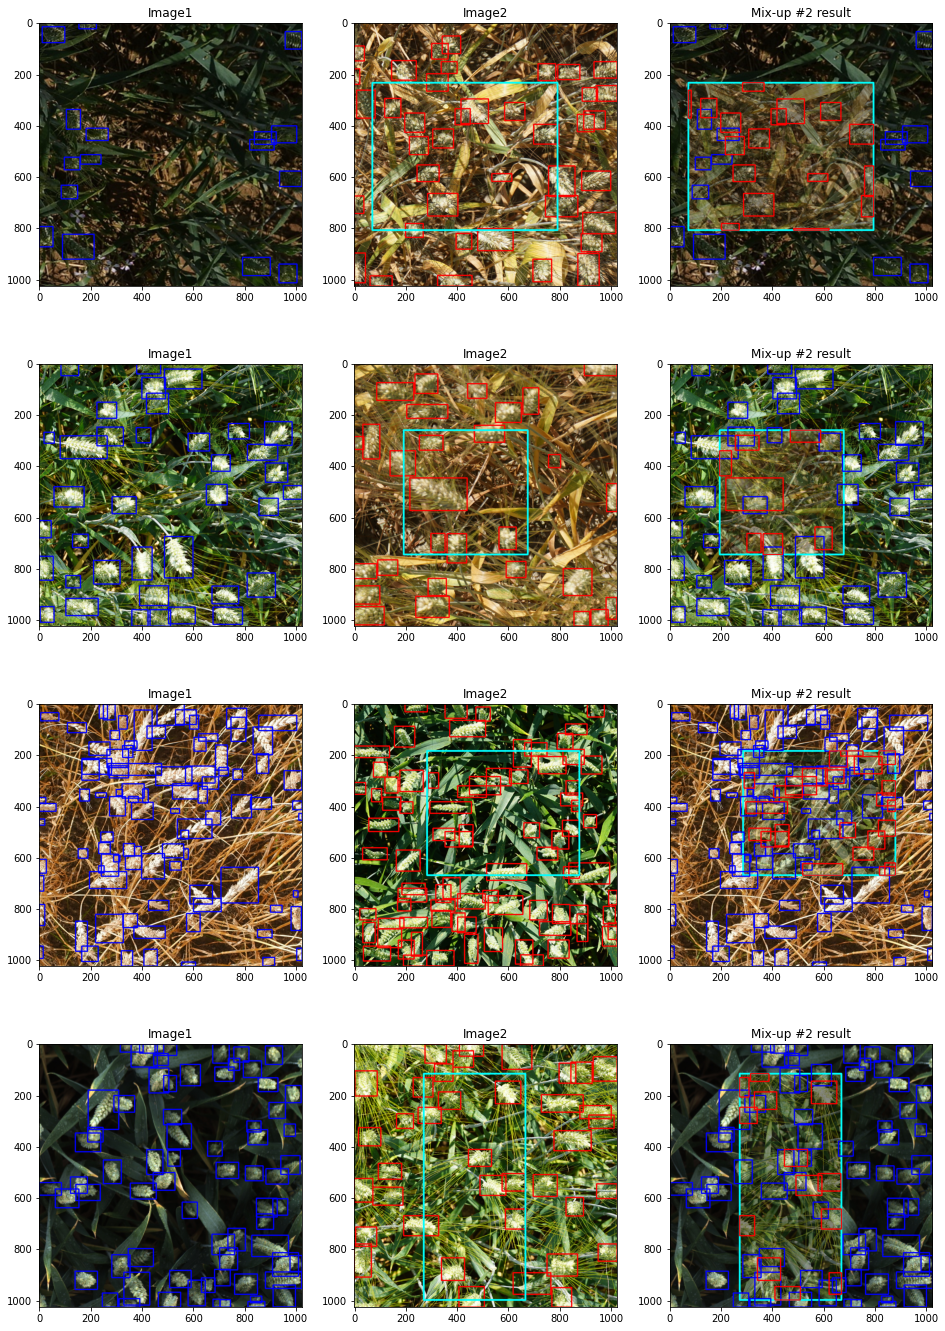

In [13]:
count = 4

fig, ax = plt.subplots(count, 3, figsize=(16, 6*count))

for i in range(count):
    image, boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    r_image, r_boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    
    for box in r_boxes.astype(int):
        cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
    
    mixup_image = image.copy()

    imsize = image.shape[0]
    x1, y1 = [int(random.uniform(imsize * 0.0, imsize * 0.45)) for _ in range(2)]
    x2, y2 = [int(random.uniform(imsize * 0.55, imsize * 1.0)) for _ in range(2)]
    
    mixup_boxes = r_boxes.copy()
    mixup_boxes[:, [0, 2]] = mixup_boxes[:, [0, 2]].clip(min=x1, max=x2)
    mixup_boxes[:, [1, 3]] = mixup_boxes[:, [1, 3]].clip(min=y1, max=y2)
    
    mixup_boxes = mixup_boxes.astype(np.int32)
    mixup_boxes = mixup_boxes[np.where((mixup_boxes[:,2]-mixup_boxes[:,0])*(mixup_boxes[:,3]-mixup_boxes[:,1]) > 0)]
    
    cv2.rectangle(r_image,(x1, y1),(x2,  y2),(0, 1, 1), 5)
    
    mixup_image[y1:y2, x1:x2] = (mixup_image[y1:y2, x1:x2] + r_image[y1:y2, x1:x2])/2
    
    cv2.rectangle(mixup_image,(x1, y1),(x2,  y2),(0, 1, 1), 5)
    
    for box in boxes.astype(int):
        cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        
    for box in mixup_boxes.astype(int):
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        
    ax[i][0].imshow(image)
    ax[i][0].set_title('Image1')
    
    ax[i][1].imshow(r_image)
    ax[i][1].set_title('Image2')
    
    ax[i][2].imshow(mixup_image)
    ax[i][2].set_title('Mix-up #2 result')

## Mix-up #3
Retrieving random box from different location in image 1 and mapping onto image 2

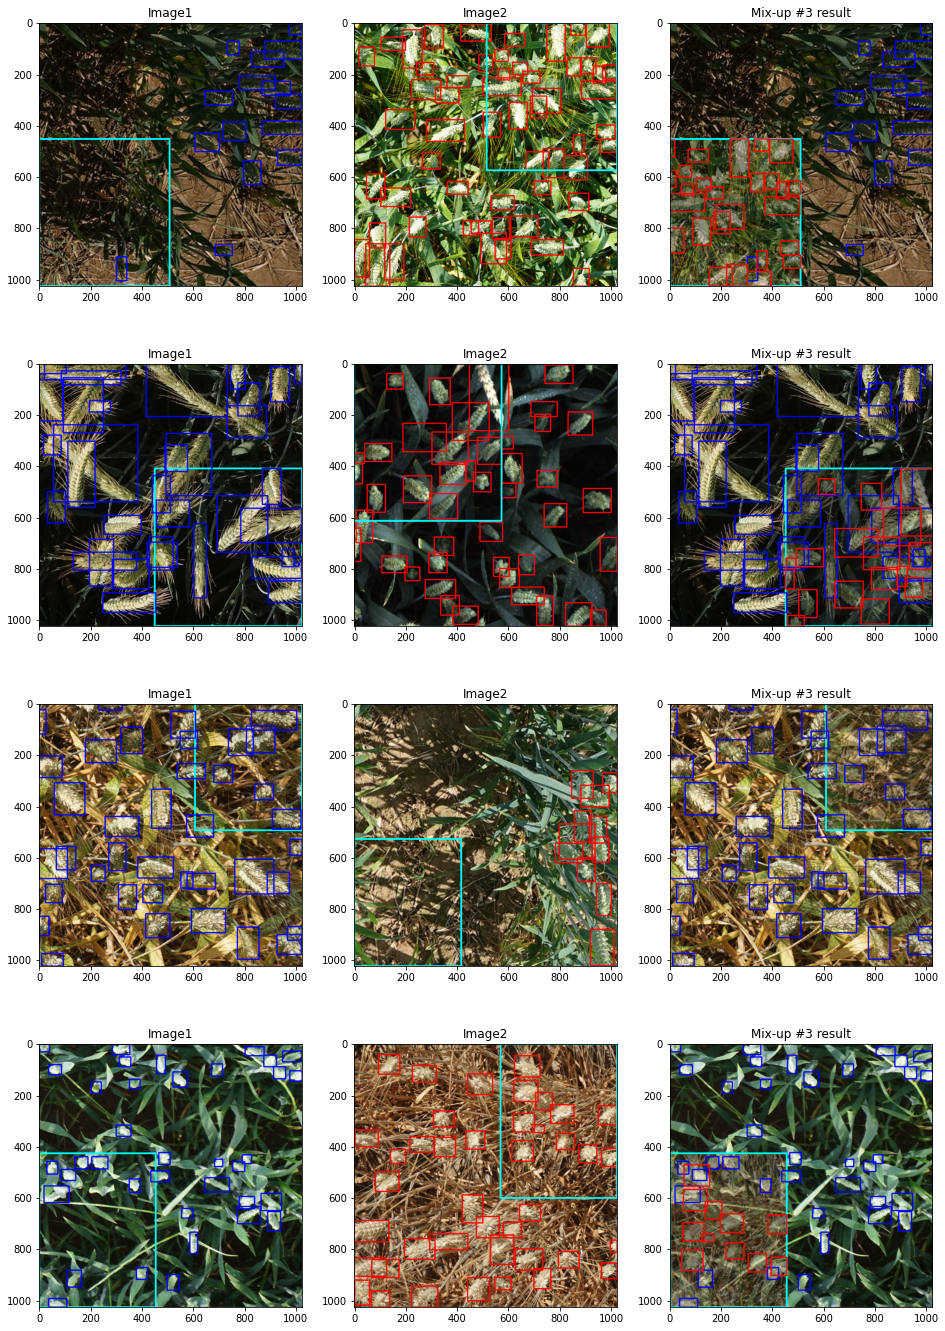

In [14]:
count = 4

fig, ax = plt.subplots(count, 3, figsize=(16, 6*count))

for i in range(count):
    image, boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    r_image, r_boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    
    for box in r_boxes.astype(int):
        cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)

    imsize = image.shape[0]
    w,h = imsize, imsize
    s = imsize // 2

    xc, yc = [int(random.uniform(imsize * 0.4, imsize * 0.6)) for _ in range(2)]
    direct = random.randint(0, 3)

    result_image = image.copy()
    result_boxes = []
    
    if direct == 0:
        x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
    elif direct == 1:  # top right
        x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
        x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
    elif direct == 2:  # bottom left
        x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
    elif direct == 3:  # bottom right
        x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
        x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

    padw = x1a - x1b
    padh = y1a - y1b

    r_boxes[:, 0] += padw
    r_boxes[:, 1] += padh
    r_boxes[:, 2] += padw
    r_boxes[:, 3] += padh
    
    result_boxes.append(r_boxes)

    result_image[y1a:y2a, x1a:x2a] = (result_image[y1a:y2a, x1a:x2a] + r_image[y1b:y2b, x1b:x2b]) / 2 
    
    cv2.rectangle(image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)
    cv2.rectangle(r_image,(x1b, y1b),(x2b,  y2b),(0, 1, 1), 5)
    cv2.rectangle(result_image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)
    
    result_boxes = np.concatenate(result_boxes, 0)
    np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
    result_boxes = result_boxes.astype(np.int32)
    result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
    
    for box in boxes.astype(int):
        cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        
    for box in result_boxes.astype(int):
        cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        
    ax[i][0].imshow(image)
    ax[i][0].set_title('Image1')
    
    ax[i][1].imshow(r_image)
    ax[i][1].set_title('Image2')
    
    ax[i][2].imshow(result_image)
    ax[i][2].set_title('Mix-up #3 result')
